# Exploring Clustering Results
The file containing the clustering results is stored in the processed data folder with the suffix clean. The index is set to the first __Product group key__.

As a reminder the file is organized in three columns: _Product Group Key_, _Cluster Number_ and the corresponding _Centroid_ of the cluster.

In [7]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)

import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import chisquare

from data.preprocessing import load_file,save_file,filter_by_season
%aimport data.preprocessing
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers = ["Product"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feature Engineering

In [908]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

Data set succefully made !
encoders saved


In [8]:
s = "Autumn"
v = 2
clustering_model = "nb_p2_clusters_%s"%(s)

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
z_data = StandardScaler(with_mean=True, with_std=True).fit_transform(sclean_df.T).T
zclean_df = pd.DataFrame(z_data,index=sclean_df.index,columns = sclean_df.columns) 

#clustering result
prd_cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = 2)

#cleaned features
features_df = load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))
features_list = list(features_df.columns) + ["Cluster"]
df = features_df.join(prd_cluster_df,how="inner")[features_list]


print(df.shape)
df.head()

(1046, 12)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore,Cluster
Product,,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.134078,Y,Autumn,0.001551,5
31C000963_2,Black,Sheer,40,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.104218,11
31C002201_2,Grey,No Size,36,18-28,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.008065,8
31C002300_2,Black,Sheer,43,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.105149,11
31C002400_2,Black,Sheer,37,29-38,Female,One-Piece Pants Inside,Thin,0.106145,$,Autumn,0.106390,8


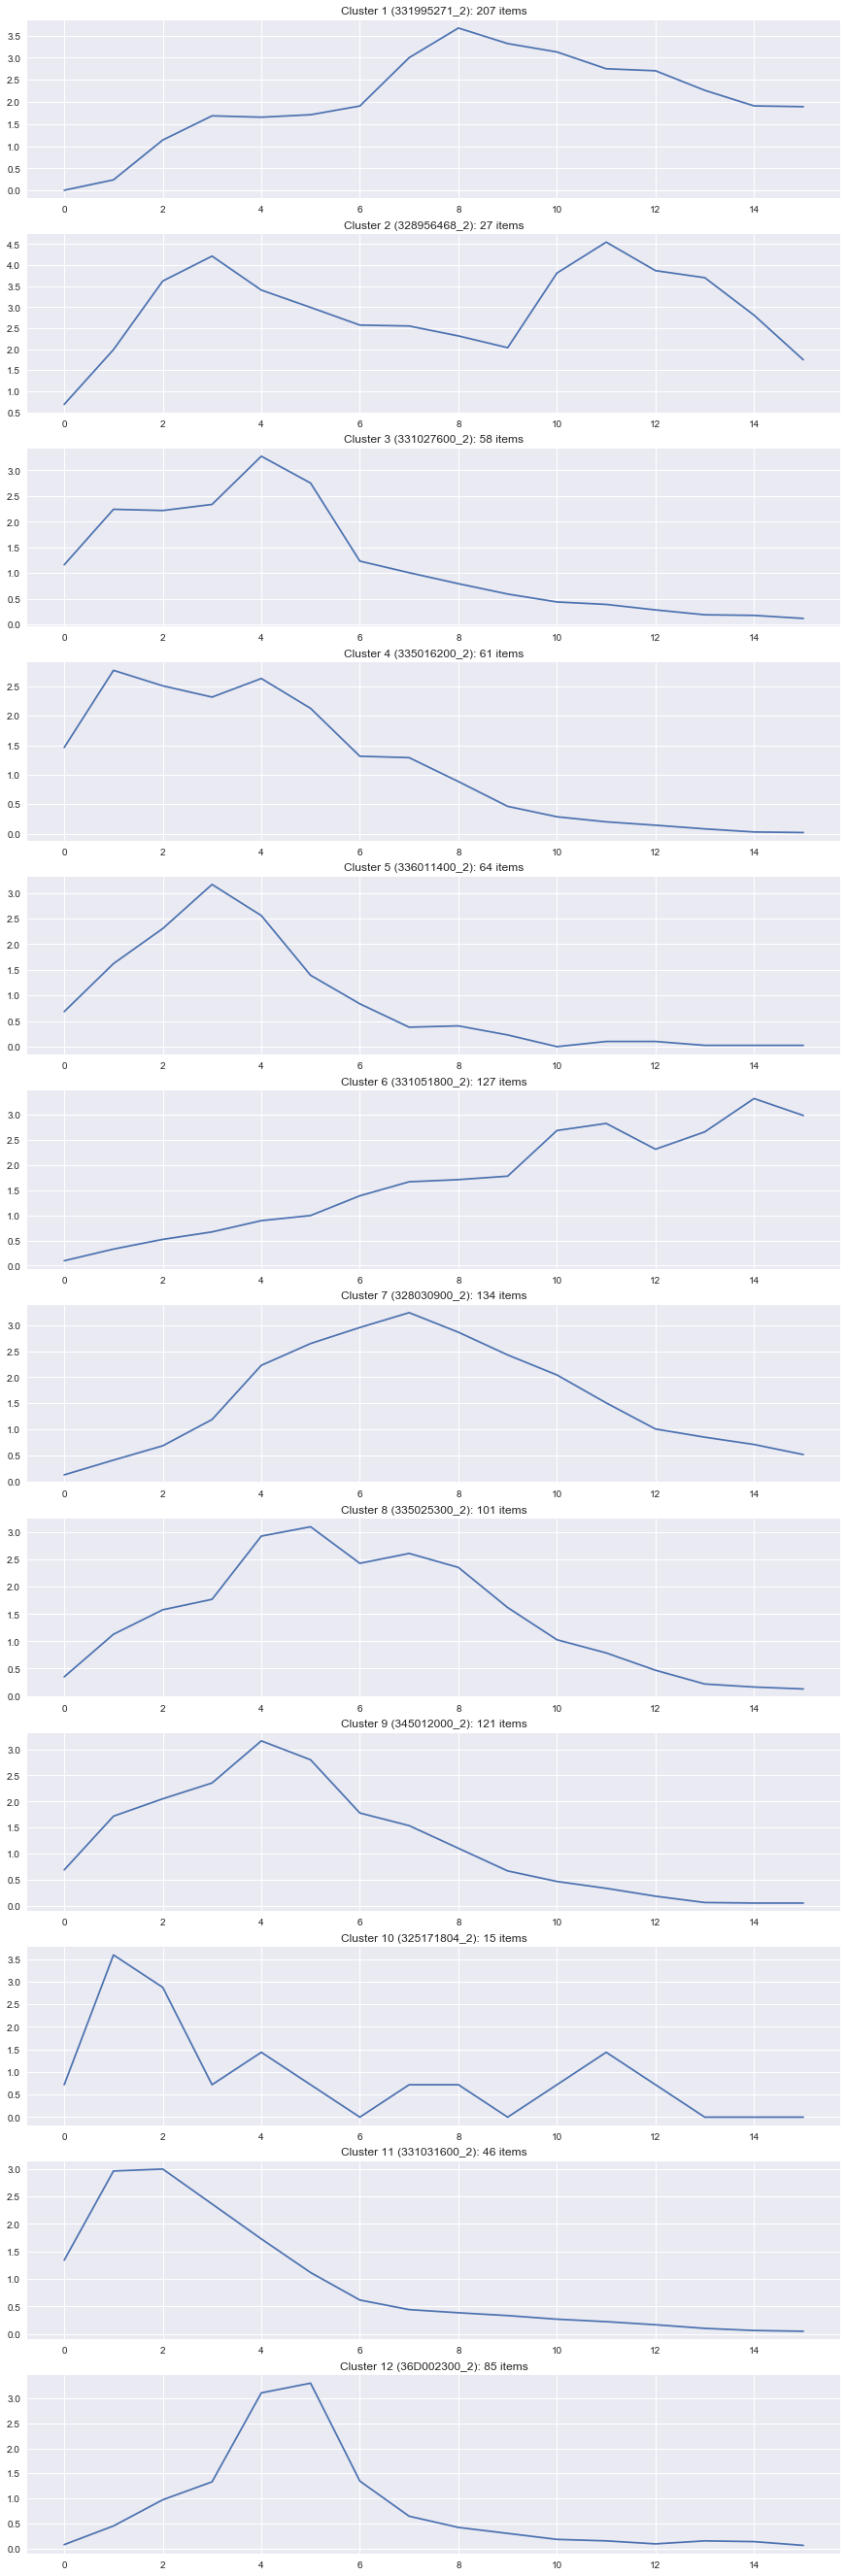

In [21]:
%matplotlib inline
from visualization import visualize as viz
%aimport visualization.visualize

plot_df = clean_df.join(prd_cluster_df,how="inner")

viz.cluster_plot(plot_df,centroid_only = True)

### Display Cluster Profiles

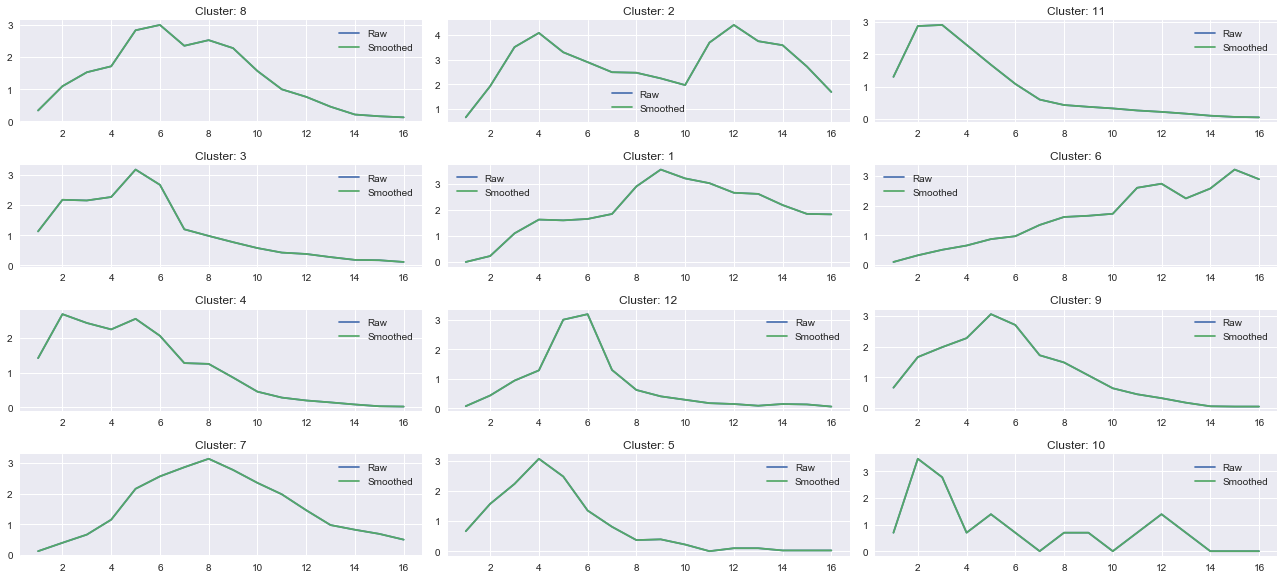

In [9]:
#Dict of cluster centroids
cluster_centroid = prd_cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


centroids = list(set(prd_cluster_df.Centroid))
centroids_raw = raw_df.loc[centroids].apply(lambda x:x/x.std(),axis=1)
centroids_clean = clean_df.loc[centroids].apply(lambda x:x/x.std(),axis=1)


n_rows = int(len(centroids)/3)+1


plt.figure(figsize=(18,n_rows*2))
i=1
for index,value in centroids_raw.iterrows():
    plt.subplot(n_rows,3,i)
    plt.title("Cluster: %d"%(centroid_cluster[index]))
    plt.plot(value,label = "Raw")
    plt.plot(centroids_clean.loc[index], label="Smoothed")
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

In [1]:
#Dict of cluster centroids
cluster_centroid = prd_cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


centroids = list(set(prd_cluster_df.Centroid))
centroids_raw = raw_df.loc[centroids].apply(lambda x:x/x.std(),axis=1)
centroids_clean = clean_df.loc[centroids].apply(lambda x:x/x.std(),axis=1)


n_rows = int(len(centroids)/3)+1


plt.figure(figsize=(18,n_rows*2))
i=1
for index,value in centroids_raw.iterrows():
    plt.subplot(n_rows,3,i)
    plt.title("Cluster: %d"%(centroid_cluster[index]))
    plt.plot(value,label = "Raw")
    plt.plot(centroids_clean.loc[index], label="Smoothed")
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

NameError: name 'prd_cluster_df' is not defined

# Homogeneity Test
In order to detect specific caraterstics for each resulted cluster we perform a statistic test based on Pearsons chi-square score with the hypothesis of a uniform distribution.

Features with the pvalues lower than 0.1 are displayed for analysis

In [23]:
%matplotlib inline
import importlib
%aimport visualization.cluster_analysis
%aimport features.tools
from visualization import cluster_analysis as va
importlib.reload(visualization.cluster_analysis)
importlib.reload(features.tools)

<module 'features.tools' from 'C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\src\\features\\tools.py'>

### Calculate modalities frequency through clusters
As a first step, all the distrubtions of modalities across features and clusters are calculated and stored in one array structered as follows:

One array for each cluster which contains a dictionnary of features. Each feature is again a dictionary of modalities and their occurence in that cluster

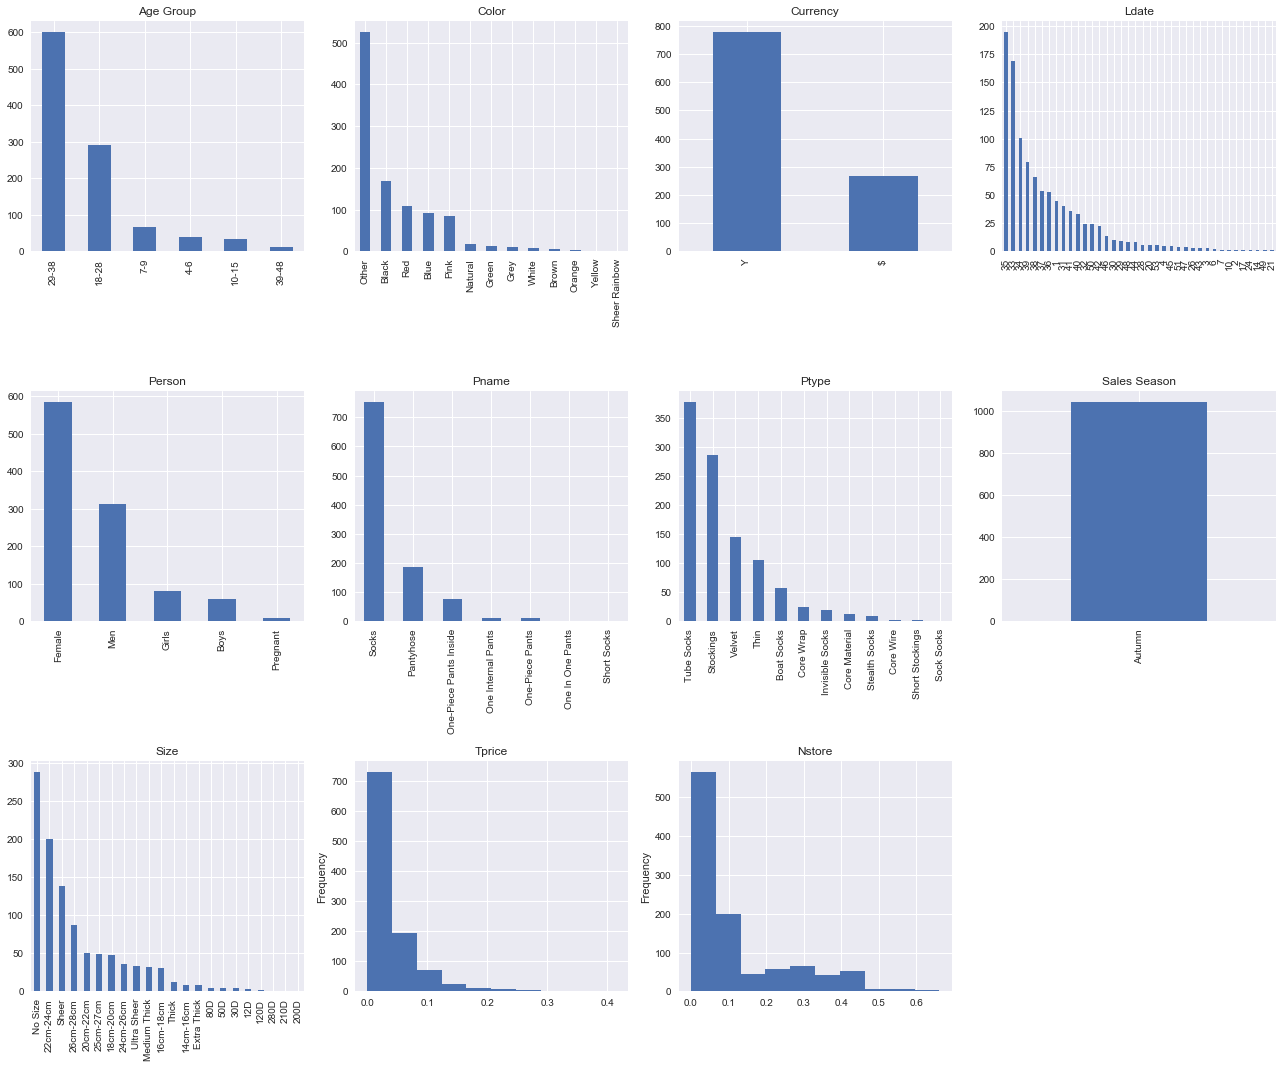

In [24]:
va.plot_features_distribution(df)

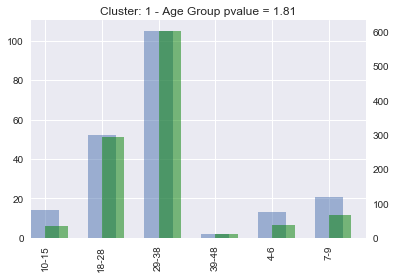

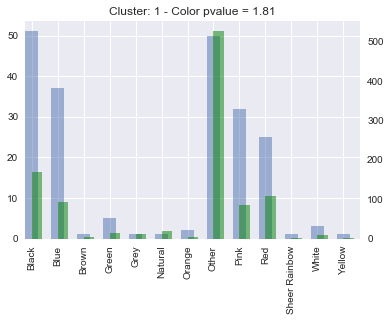

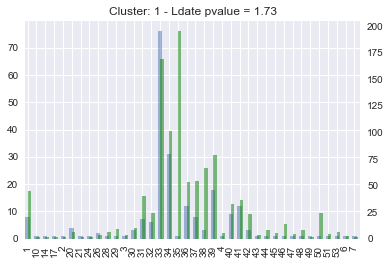

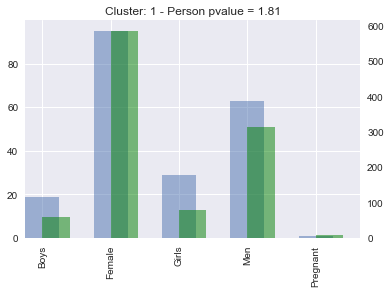

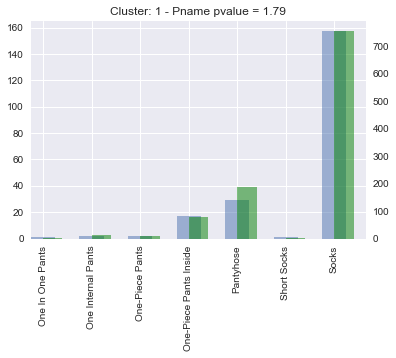

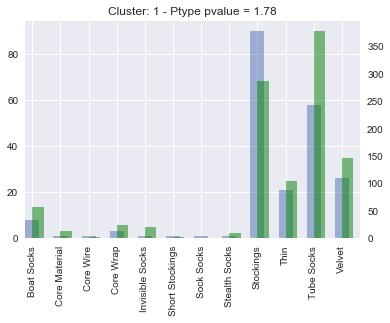

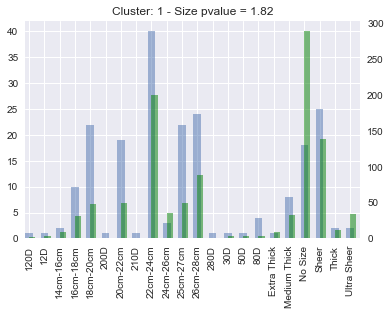

In [25]:
va.plot_cluster_over_features(df,clusters=[1]);

In [ ]:
va.plot_feature_over_clusters(df,"Ptype");

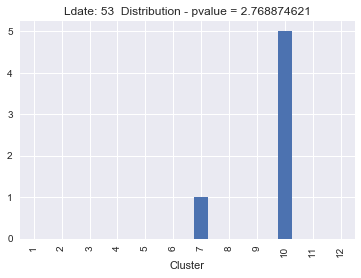

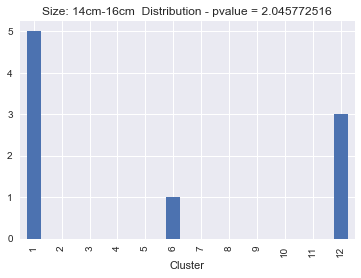

In [13]:
va.plot_modalities(df);

## MCA Analysis

### Apply MCA on Products

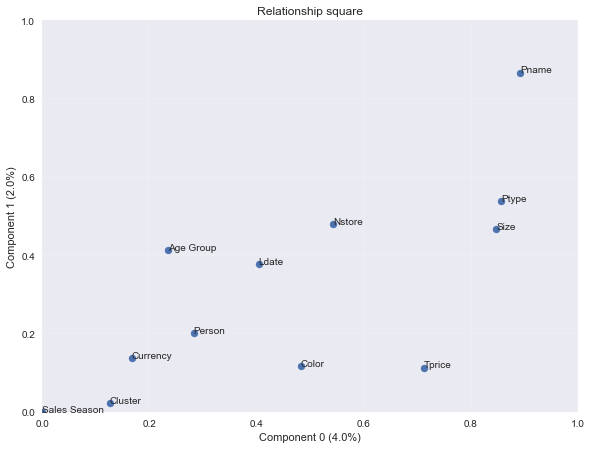

In [57]:
va.mca_plot(df)

# Clients

### Apply MCA on Clients

In [ ]:
client_df = load_file("client",index = "Key_lvl1")

In [96]:
client_df.head()

,Description,Key_lvl2,Key_lvl3,Key_lvl4,Opening Date,City Level,Port Type,Operation State,Store Type,Store Level,Business Area,Store Style,Status
Key_lvl1,,,,,,,,,,,,,
01257,NaN,British area,Sichuan Branch,Total,2012-04-16,Level 4,Residential Community,Opening as normal,Single-layer Store,Level E,150.00,First-generation,Active
01258,NaN,Guangba area,Sichuan Branch,Total,2012-05-12,Level 2,Residential Community,Opening as normal,Single-layer Store,Level C,95.94,First-generation,Active
01259,NaN,The area,Sichuan Branch,Total,2012-05-06,Level 3,Residential Community,Opening as normal,Single-layer Store,Level E,140.00,First-generation,Active
01262,NaN,Guanghan area,Sichuan Branch,Total,2012-06-05,Level 4,Residential Community,Opening as normal,Single-layer Store,Level D,240.00,Second-generation,Active
01264,NaN,Independent Second District,Sichuan Branch,Total,2012-06-01,Level 1,Residential Community,Opening as normal,Single-layer Store,Level B,180.00,Second-generation,Active


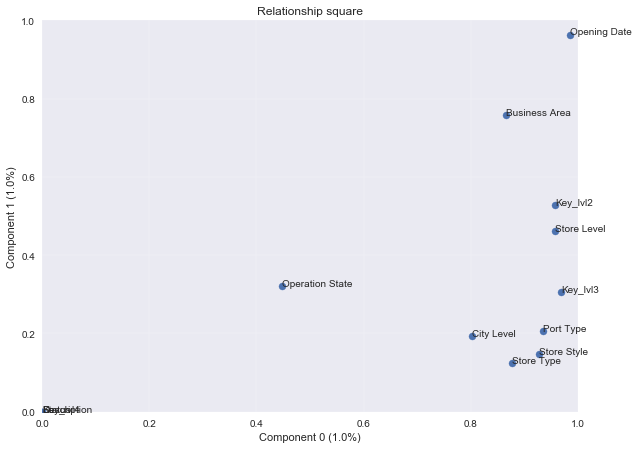

In [94]:

features_df = client_df.astype(str).fillna("NA")
va.mca_plot(features_df)

## '###########################################################################'

### Display overall features distribution

In [ ]:
features_df = df.fillna("Na").drop("Cluster",axis=1).copy()

original_distribution={}

# features_df.info()
plt.figure(figsize=(16,16))
features = features_df.columns
for i,f in enumerate(features):
    counts = features_df.groupby([f])[f].count().to_dict()
    dist = list(counts.values())
    original_distribution[f] = dist
    keys = list(counts.keys())
    chisq, p = chisquare(dist)
    plt.subplot(5,4,i+1)
    plt.title("%s"%(f))
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    if len(keys)>20: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)      
plt.show()

### Chi-square test over clusters

In [ ]:

pthreashold = 0.2

#get the features
features = all_features

clusters = [4]


res_features_over_cluster = [0]
for c in clusters:
    #align each feature with its distrubtion in this cluster c
    cluster_feature_dist = clusters_feature_dist[c]
    dist = [len(x) for x in list(cluster_feature_dist.values())]
    keys = list(cluster_feature_dist.keys())    

    #plot the dist of number of elements by feature in this clust
    plt.title("Feature distribution in the cluster %d"%c)
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    
    #for each feature display its distribution over modalities
    for feature in features:
        #get information from the previous array
        cluster_feature_dist = clusters_feature_dist[c]
        feature_distribution = list(cluster_feature_dist[feature].values())
        feature_keys = list(cluster_feature_dist[feature].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        print(feature,feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s modalities distribution - pvalue = %.9f"%(feature,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(0.5/nftrs),feature_keys,rotation=70 if nftrs>4 else 0)
    plt.show(block = True)
    


### Calculate modalities frequency through features

In [ ]:
#get the features
features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(df['Cluster'].values)

#dict to store each feater and freq for all the clusters
features_clust_dist = dict()

#invert the dict and get it by feature 
for f in features:
    freq = dict()
    for c in clusters: 
        freq[c] =  clusters_feature_dist[c][f]
    features_clust_dist[f] = freq

### Chi-square test over features

In [ ]:
pthreashold = 0.2
clusters = set(df['Cluster'].values)

features = all_features
features = ["Ldate"]

for f in features:
    for c in clusters:
        #get information from the previous array
        feature_clust_dist = features_clust_dist[f]
        feature_distribution = list(feature_clust_dist[c].values())
        feature_keys = list(feature_clust_dist[c].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s: Cluster %d distribution - pvalue = %.9f"%(f,c,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
            
    plt.show(block = True)     



### Modalities distribution

In [ ]:
clusters = set(df['Cluster'].values)
nclusters = len(clusters)
#get the features
features = all_features


modalities_clust_dist = dict()

for f in features:
    feature_sum=[]
    modalities = set(df[f].values)
    modalities_distribution=dict()
    for m in modalities:
        modality_distribution = np.zeros((nclusters+1))
        for c in clusters:
            #get information from the previous array
            feature_clust_dist = features_clust_dist[f]
            modality_distribution[c] +=(feature_clust_dist[c][m] if m in feature_clust_dist[c] else 0)
        modalities_distribution[m] = modality_distribution    
    modalities_clust_dist[f] = modalities_distribution 

### Chi-square test for modalities over clusters

In [ ]:
%matplotlib inline

clusters = set(df['Cluster'].values)
nclusters = len(clusters)


pthreashold = 0.3

n_min_dist = 3
min_members = 4


min_dust  = True
for f in features:
    modalities = set(df[f].values)
    r = len(modalities)
    for m in modalities:
        modality_dist = modalities_clust_dist[f][m]
        md = np.count_nonzero(modality_dist)<=n_min_dist and np.max(modality_dist)>min_members
        chisq, p = chisquare(modality_dist)
        if p<pthreashold and (md and min_dust):
            plt.figure()
            plt.title("%s: %s  Distribution - pvalue = %.9f"%(f,m,p))
            plt.bar(np.arange(nclusters)+1,modality_dist[1:])
            plt.xticks(np.arange(nclusters)+(1.0/nclusters)+1,np.arange(nclusters)+1,rotation=90,size=8)
            if np.max(modality_dist[1:])<10: plt.ylim(0,10)
    plt.show(block = True)  

In [ ]:
#get the features
all_features = df.columns[:-1]


features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(df['Cluster'].values)

#array to store each cluster and freq for all the features
clusters_feature_dist = [0] #to shift the indices to clusters

#loop trhough features
display(df.Color.value_counts())
display(pd.crosstab(df.Cluster,df.Color))
for c in clusters:
    feature_dist = dict()
    for feature in features:
        freq = df[df['Cluster']==c].groupby(feature)[feature].count()
        feature_dist[feature]=freq.to_dict()
    clusters_feature_dist.append(feature_dist)



## Classification Models

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.tree import  export_graphviz
import subprocess


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=True )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


features_df = df[features_list].copy()
data = features_df.copy()
data["Sales Season"] = "Summer"
print(data.shape)
display(data.head())

In [ ]:
# X  = pd.get_dummies(data.drop(["Cluster"],axis=1).iloc[:,:])
X = prp.encode(data.drop(["Cluster"],axis=1),non_categorical = numeric)
# X.drop(["Nstore"], axis= 1,inplace = True)
feature_labels = X.columns
y = data["Cluster"]
print(X.shape)

series = clean_df.iloc[:,:3].copy()
series = series.apply(lambda x:x / x.std())


X_s = X.join(series)

# classifier = DecisionTreeClassifier(criterion = "gini", max_depth=3, min_samples_leaf=4)  
# classifier = SVC(C=0.1, class_weight='balanced')
classifier = RandomForestClassifier(n_estimators=100,max_depth=12)
# classifier = KNeighborsClassifier(n_neighbors=15,weights='uniform', algorithm='auto');
# classifier = MLPClassifier(hidden_layer_sizes=(16,8),solver='lbfgs',max_iter=2000,verbose = True)#8,5
# classifier = GaussianNB()
X.head(3)
# classifier = DummyClassifier()
# y = y.sample(frac=1)
# y.head()

## Standard evaluation metrics of the algorithm

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

classifier = RandomForestClassifier(n_estimators=80,max_depth=18,min_samples_split=2, min_samples_leaf=1, criterion='gini', bootstrap=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)  


# scores = cross_val_score(classifier, X, y, cv=5, scoring='f1_macro')
# print(scores,scores.mean())


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)
yt_pred = classifier.predict(X_train)

# print(confusion_matrix(y_test, y_pred) 
# precision,recall,fscore,support = report(y_test, y_pred,warn_for=(),labels=np.unique(y_pred))
print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_test) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

### Random Search

In [ ]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


clf = RandomForestClassifier(n_estimators=200)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
              "max_depth": [10, None],
              "max_features": [None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

### Grid Search

In [ ]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


clf = RandomForestClassifier()

param_grid = {"n_estimators":[50,80,100,150,200],
              "max_depth": [8, 10, 12, 15, 20],
              "max_features": [None],
              "min_samples_split": [2, 3, 6, 10],
              "min_samples_leaf": [1, 3, 6, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(random_search.cv_results_)

## RMSE to the center of the predicted cluster 

#### Joining the series with the predicted clusters of the test set

In [ ]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = prd_cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(prd_cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])


### Top-4 Error rate and correlation

In [ ]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 2

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
RMSE = []
PRMSE = []
CORR = []
SP=[]
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    rmse = math.sqrt(MSE(series,c_series)/n)
    prmse = math.sqrt(MSE(series,predicted_series)/n)
    corr = np.corrcoef(series,predicted_series)[0][1]
    
    RMSE.append(rmse)
    PRMSE.append(prmse)
    CORR.append(corr)
    i+=1
    
  
sales = p_series.values[:,offset:].astype(np.float64)
p_series["PRMSE"] = PRMSE
p_series["RMSE"] = RMSE
p_series["CORR"] = CORR
results = pd.DataFrame(index = p_series.index)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = RMSE
results["PRMSE"] = PRMSE
results["CORR"] = CORR


print("%.2f have less than 70%% correlation between predicted and actual series"%(results[results.CORR<0.7].shape[0]/N*100))


results[results.PRMSE != results.RMSE].nlargest(210,"PRMSE").head(5)

### Predictions Plots

In [ ]:
bad = p_series[p_series.PRMSE != p_series.RMSE].nlargest(210,"PRMSE")
good = p_series[p_series.CORR>0.8]


disp = p_series.iloc[:,:-3].loc[bad.index[:12]]
display(disp.head())




plt.figure(figsize=(18,8))
i=1;
for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
    plt.plot(predicted_series,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities

### Load features and predictor

In [ ]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

features_df = prp.load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))


from sklearn.externals import joblib


features_df.head()
encoded_df = prp.encode(features_df,non_categorical = ["Tprice","Nstore"])

encoded_df.head()

### Estimations

In [ ]:
predictor = joblib.load(models_path+'estimator.pkl')

disp = p_series.iloc[:,:-3].loc[results.index[0:12]]
disp = p_series.iloc[:,:-3]

R2 = []
RMSE = []
BEST = []
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    rmse1 = math.sqrt(MSE(p1,series)/n)
    rmse2 = math.sqrt(MSE(p2,series)/n)
    rmse3 = math.sqrt(MSE(p3,series)/n)
    rmse4 = math.sqrt(MSE(p4,series)/n)
    
    r2_1 = r2_score(p1,series,multioutput="uniform_average")
    r2_2 = r2_score(p2,series,multioutput="uniform_average")
    r2_3 = r2_score(p3,series,multioutput="uniform_average")
    r2_4 = r2_score(p4,series,multioutput="uniform_average")
    
    r2 = [r2_1,r2_2,r2_3,r2_4]
    rmse = [rmse1,rmse2,rmse3,rmse4]
    best = np.argmin(rmse)
    
    BEST.append(best)
    R2.append(r2[best])
    RMSE.append(rmse[best])
    
disp["R2"] = R2
disp["RMSE"] = RMSE
disp["Best"] = BEST
display(disp[disp.R2>0.2].R2.describe())
disp[disp.R2>0.2].R2.plot(kind="box")
print(disp[disp.R2>0.2].R2.count()/disp.shape[0])
plt.show()

### Display First Prediction

In [ ]:
display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))


i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    
    best = disp.loc[index].Best
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.plot(p1,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     plt.plot(p4,label="P4",ls='--')



    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

### Adjusted Prediction

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    
    first_points = series[:n_points]/series[:n_points].std()
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
    cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
    p1c = p1 * cstd 
    p1p = p1 * pstd[0]
    c_series *= cstd
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p1p,label="P1_pstd",ls='--',c='y')
    plt.plot(p_array.iloc[closest]*cstd,label="Closest",c='g',ls=':')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

In [ ]:
p = ["325141400_2"]
features_df.loc[p]
series_df.loc[p]
p_series.loc[p]

In [ ]:
from sklearn.grid_search import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

## Get clients description

In [79]:
file_name = "client_7cerf.txt"
non_unique_features = []
unique_features = []

client_df = pd.read_csv(raw_path+file_name, sep='\t', encoding='utf-8').fillna("NA")
                    #.drop_duplicates()

#client_df.to_csv(raw_path+"client_7cerf.csv",sep=';',encoding='utf-8')
print(client_df.shape)
client_df.head()

(433, 14)


,Key_lvl1,Description,Key_lvl2,Key_lvl3,Key_lvl4,Opening Date,City Level,Port Type,Operation State,Store Type,Store Level,Business Area,Store Style,Status
0,01257,NA,大英区域,四川分公司,Total,2012-04-16,Level 4,Residential Community,Opening as normal,Single-layer Store,Level E,150,First-generation,Active
1,01258,NA,广巴区域,四川分公司,Total,2012-05-12,Level 2,Residential Community,Opening as normal,Single-layer Store,Level C,95.94,First-generation,Active
2,01259,NA,什绵区域,四川分公司,Total,2012-05-06,Level 3,Residential Community,Opening as normal,Single-layer Store,Level E,140,First-generation,Active
3,01262,NA,广汉区域,四川分公司,Total,2012-06-05,Level 4,Residential Community,Opening as normal,Single-layer Store,Level D,240,Second-generation,Active
4,01264,NA,独立二区,四川分公司,Total,2012-06-01,Level 1,Residential Community,Opening as normal,Single-layer Store,Level B,180,Second-generation,Active


In [80]:
client_df["Store Level"].value_counts()

Level C       120
Level D        90
N              73
Level E        70
Level B        42
Level A        24
Standard       11
Duty-free       2
Large-size      1
Name: Store Level, dtype: int64

In [81]:
%aimport external.df_translator
from external import df_translator

translator = df_translator.DFTranslator()

# translator.create_dictionnary(client_df,columns = ["Key_lvl2","Key_lvl3"])

In [90]:
dic = translator.load_dictionnary(raw_path+"cl_dictionnary")
client_df = translator.translate_df(client_df,["Key_lvl2","Key_lvl3"],dictionnary = dic)

In [91]:
prp.save_file(client_df,"client",index = False)

## Get Products description
In order to get the product features description, an inner join on the product group key is operated on the cluster result with the products description file.

Since the clustering was calculated on the second level group, some columns of the description file must be dropped in order to avoid duplicates of the first level products (mainly Promo and Standard version of the products)

In [1397]:
file_name = "product_7cerf.txt"

non_unique_features=[]

code_features = []



df_produit = pd.read_csv(raw_path+file_name, sep='\t',encoding="utf8")


                
# df_produit = df_produit.drop(code_features,axis=1)
# df_produit = df_produit.drop_duplicates()
# df_produit = df_produit.dropna(how="all")
# df_produit = df_produit.reset_index(drop=True)
# df_produit = df_produit.apply(lambda x:x.astype(str).str.upper())


df_produit = df_produit.drop_duplicates(["Key_lvl2","Description"])


print(df_produit.shape)
df_produit.head()

(51349, 22)


,Key_lvl1,Description,Key_lvl2,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Key_lvl7,Continuation of,Base Price 1 Target Value,...,Size,Gender,Year of Commodity,Launch Date,Tag Price,Product Status,Sales Season,Continuation,Age Group,Product ABC Classification
0,20300138600,RQC-老人头棉袜BL0017,203001386_2,男-短袜-长筒袜-8.25元,男-短袜-长筒袜,男-短袜,男,袜子,NaN,8.0,...,JM,No Gender,2011,01/01/1900,8.25,D,Autumn,NO,29-38,NaN
1,20300329000,RQC-国奥棉袜BL4038,203003290_2,男-短袜-长筒袜-4.38元,男-短袜-长筒袜,男-短袜,男,袜子,NaN,4.0,...,JM,No Gender,2011,01/01/1900,4.38,D,Autumn,NO,29-38,NaN
2,20300355500,RQC-爱国者棉袜BL010,203003555_2,男-短袜-长筒袜-4.76元,男-短袜-长筒袜,男-短袜,男,袜子,NaN,5.0,...,JM,No Gender,2011,01/01/1900,4.76,D,Autumn,NO,29-38,NaN
3,20300418700,RQC-老人头棉袜BL0020,203004187_2,男-短袜-长筒袜-8.25元,男-短袜-长筒袜,男-短袜,男,袜子,NaN,8.0,...,JM,No Gender,2011,01/01/1900,8.25,D,Autumn,NO,29-38,NaN
4,20300419000,RQC-老人头棉袜BL0021,203004190_2,男-短袜-长筒袜-7.5元,男-短袜-长筒袜,男-短袜,男,袜子,NaN,8.0,...,JM,No Gender,2011,01/01/1900,7.50,D,Autumn,NO,29-38,NaN


In [2136]:
df_produit.iloc[:,5:-5].head()

,Key_lvl5,Key_lvl6,Key_lvl7,Continuation of,Base Price 1 Target Value,Base Price 1 Coefficient Table,Color,Size,Gender,Year of Commodity,Launch Date,Tag Price
0,男-短袜,男,袜子,NaN,8.0,NaN,No Color,JM,No Gender,2011,01/01/1900,8.25
1,男-短袜,男,袜子,NaN,4.0,NaN,No Color,JM,No Gender,2011,01/01/1900,4.38
2,男-短袜,男,袜子,NaN,5.0,NaN,No Color,JM,No Gender,2011,01/01/1900,4.76
3,男-短袜,男,袜子,NaN,8.0,NaN,No Color,JM,No Gender,2011,01/01/1900,8.25
4,男-短袜,男,袜子,NaN,8.0,NaN,No Color,JM,No Gender,2011,01/01/1900,7.50


In [2137]:
df_produit["Tag Price"].value_counts()

9.00      4221
10.00     3606
12.00     3425
15.00     2932
7.00      2437
          ... 
27.75        1
61.74        1
216.00       1
9.31         1
15.90        1
Name: Tag Price, dtype: int64

## Table of products and  clusters

In [1398]:
unbalanced = ["Description","Key_lvl7","Product Status"]#,"Sales Season"

#Join with clusters
product_cluster = df_produit.join(df_prd_cluster,on='Key_lvl2',how='inner').reset_index(drop = True).dropna(axis = 1)
product_cluster.drop(unbalanced, axis = 1 , inplace=True)
rw = product_cluster.copy()

prp.display(product_cluster)

#product_cluster.to_csv(interim_path+"product_cluster.csv",sep=";",encoding="utf-8")

(1046, 17)


,Key_lvl1,Key_lvl2,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Base Price 1 Target Value,Color,Size,Gender,Year of Commodity,Launch Date,Tag Price,Sales Season,Age Group,Cluster,Centroid
0,31C0009635602,31C000963_2,女-内穿一体裤-薄型-29元,女-内穿一体裤-薄型,女-内穿一体裤,女,29.0,Black,Sheer,No Gender,2016,05/10/2016,29.0,Autumn,29-38,8,335030700_2
1,31C0022017000,31C002201_2,女-内穿一体裤-薄型-29元,女-内穿一体裤-薄型,女-内穿一体裤,女,29.0,Gray,No Size,No Gender,2016,08/09/2016,29.0,Autumn,18-28,4,345010900_2
2,31C0023005602,31C002300_2,女-内穿一体裤-薄型-29元,女-内穿一体裤-薄型,女-内穿一体裤,女,29.0,Black,Sheer,No Gender,2016,25/10/2016,29.0,Autumn,29-38,8,335030700_2
3,31C0024005602,31C002400_2,女-内穿一体裤-薄型-39元,女-内穿一体裤-薄型,女-内穿一体裤,女,39.0,Black,Sheer,No Gender,2017,15/09/2017,39.0,Autumn,29-38,2,338013800_2
4,31C0025005602,31C002500_2,女-内穿一体裤-薄型-29元,女-内穿一体裤-薄型,女-内穿一体裤,女,29.0,Black,Sheer,No Gender,2017,11/09/2017,29.0,Autumn,18-28,6,34B000000_2


## Translate Features

#### Load chinese features and translate them

#### Create a CH==>EN dictionnary for all the features and save it to a file

#### Load the dictionnary file

### Translate the products dataframe

In [1399]:
product_cluster = prp.translate_df(product_cluster,columns=["Key_lvl3","Key_lvl4","Key_lvl5","Key_lvl6"])
prp.display(product_cluster)   

(1046, 17)


,Key_lvl1,Key_lvl2,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Base Price 1 Target Value,Color,Size,Gender,Year of Commodity,Launch Date,Tag Price,Sales Season,Age Group,Cluster,Centroid
0,31C0009635602,31C000963_2,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,29.0,Black,Sheer,No Gender,2016,05/10/2016,29.0,Autumn,29-38,8,335030700_2
1,31C0022017000,31C002201_2,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,29.0,Gray,No Size,No Gender,2016,08/09/2016,29.0,Autumn,18-28,4,345010900_2
2,31C0023005602,31C002300_2,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,29.0,Black,Sheer,No Gender,2016,25/10/2016,29.0,Autumn,29-38,8,335030700_2
3,31C0024005602,31C002400_2,Female - One-piece pants inside - Thin - $39,Female - One Internal Pants - Thin,Female - One-piece pants,Female,39.0,Black,Sheer,No Gender,2017,15/09/2017,39.0,Autumn,29-38,2,338013800_2
4,31C0025005602,31C002500_2,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,29.0,Black,Sheer,No Gender,2017,11/09/2017,29.0,Autumn,18-28,6,34B000000_2


## Merge Products and Clients tables

Save the final result into a csv file for further exploration

In [1400]:
filename = "p2_clustering_clean_week_3.csv"
product_cluster.to_csv(processed_path+filename,sep=';',encoding='utf-8')

## Exploratory Data Analysis